In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
X = pd.DataFrame()

for i in [1, 2, 3, 4]:
    for j in [1, 2, 3, 4, 5]:
        features_yml = 'lfr_graphs/mu_0_{0}/graph_0{1}/graph_0{1}_mu_0_{0}_node_features.yml'.format(i, j)
        with open(features_yml) as f:
            feat = yaml.load(f, Loader=yaml.Loader)
        df = pd.DataFrame(feat)
        new_indices = ['graph_{0}_{1}_node_{2}'.format(i, j, k) for k in range(200)]
        df.index = new_indices
        X = pd.concat([X, df])

In [3]:
from scipy.stats import entropy

node_entropies = []

for i in [1, 2, 3, 4]:
    for j in [1, 2, 3, 4, 5]:
        coassociation_yml = 'lfr_graphs/mu_0_{0}/graph_0{1}/graph_0{1}_mu_0_{0}_coassociation.yml'.format(i, j)
        with open(coassociation_yml) as f:
            x = yaml.load(f, Loader=yaml.Loader)
        entropies = entropy(x) / x.shape[0]
        node_entropies += list(entropies)
        
node_entropies = np.array(node_entropies)

In [13]:
def assign_y(cut):
    y = np.where(node_entropies < cut, 0, 1)
    y = pd.DataFrame(y, index=X.index, columns=['Stability'])
    return y

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [7]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
    feature_list = list(X_train.columns)
    data = np.array(X_train)
    labels = np.squeeze(np.array(y_train))
    return feature_list, data, labels

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [9]:
runs = 100

In [10]:
def train(feature_list, data, labels):
    accuracy_scores = []

    skf = StratifiedKFold(n_splits=5)
    rf = RandomForestClassifier()

    for run in range(1, runs+1):

        for i in range(5):
            folds = next(skf.split(data, labels), None)

            X_train_fold = data[folds[0], :]
            X_val_fold = data[folds[1], :]
            y_train_fold = labels[folds[0]]
            y_val_fold = labels[folds[1]]

            model = rf.fit(X_train_fold, y_train_fold)
            predictions = rf.predict(X_val_fold)

            accuracy_scores.append(metrics.accuracy_score(y_val_fold, predictions))

    return accuracy_scores

In [11]:
cutoff_values = [0.015, 0.016, 0.017, 0.0175, 0.018, 0.0185, 0.019, 0.0195, 0.020, 0.021, 0.022]

In [12]:
mean_accuracies = []

In [14]:
from tqdm import tqdm

In [15]:
for cut in tqdm(cutoff_values):
    y = assign_y(cut)
    feature_list, data, labels = split_data(X, y)
    accuracy_scores = train(feature_list, data, labels)
    y_acc = np.mean(accuracy_scores)
    mean_accuracies.append(y_acc)

100%|██████████| 11/11 [29:18<00:00, 159.91s/it]


Text(0, 0.5, 'Mean accuracy')

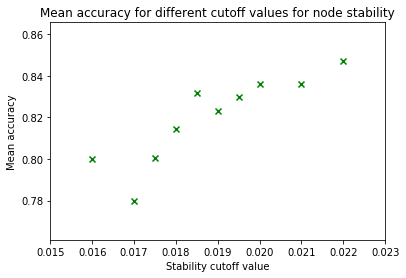

In [22]:
plt.scatter(cutoff_values[1:], mean_accuracies[1:], marker='x', c='green')
plt.title('Mean accuracy for different cutoff values for node stability')
plt.xlim(0.015, 0.023)
plt.xlabel('Stability cutoff value')
plt.ylabel('Mean accuracy')